In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek

In [4]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
0,2022-01-01,25,187.148310,79439.490943,3972,5
1,2022-01-02,21,651.090018,46402.445157,2581,6
2,2022-01-03,10,2469.903372,33963.973956,2096,0
3,2022-01-04,10,-146.716214,13660.124678,1361,1
4,2022-01-05,14,-822.788468,59365.320499,2295,2


#### Heads прогнозирование

<Axes: xlabel='Date'>

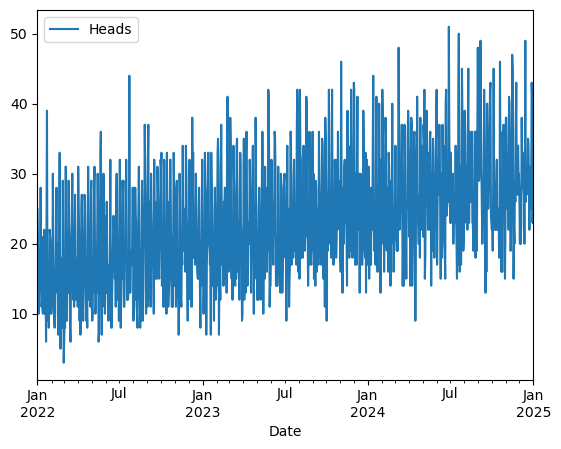

In [5]:

casino_fig[:].plot(x="Date", y ="Heads")


### Разделяем на тренингувую и тестовую выборку

In [6]:
casino_fig_train = casino_fig[casino_fig['Date'] < datetime(2024,11,1) ]
casino_fig_test = casino_fig[casino_fig['Date'] >= datetime(2024,11,1) ]

In [7]:
casino_fig_test.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1035,2024-11-01,38,-3575.173010,130799.110137,5291,4
1036,2024-11-02,38,-3016.804312,108763.094155,5980,5
1037,2024-11-03,31,1762.656643,69375.598244,3913,6
1038,2024-11-04,25,-2487.864214,52287.466384,2517,0
1039,2024-11-05,26,977.800316,72808.600748,3563,1


In [8]:
casino_fig_train.tail()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1030,2024-10-27,37,-360.526579,172685.461593,5955,6
1031,2024-10-28,25,203.917613,29521.625537,2613,0
1032,2024-10-29,24,-1210.990059,73069.113052,3961,1
1033,2024-10-30,15,3625.931075,75718.537008,3502,2
1034,2024-10-31,22,685.872606,50127.396778,4053,3


### Вычисляем Тренд

In [9]:
coefficients = np.polyfit(casino_fig_train.index,casino_fig_train['Heads'], 1)
print(coefficients)

[1.30654171e-02 1.61659523e+01]


In [10]:
poly_1 = np.poly1d(coefficients)

In [11]:
casino_fig_train['trend_heads']= poly_1(casino_fig_train.index)

<Axes: xlabel='Date'>

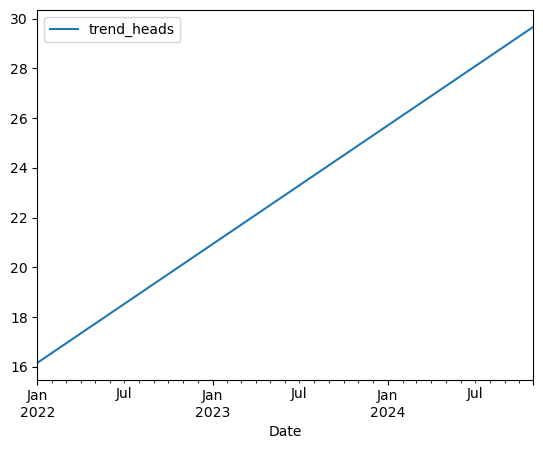

In [12]:
casino_fig_train.plot(x="Date", y ="trend_heads")

### Очищаем от тренда

In [13]:
casino_fig_train['heads_center_and_clear']=casino_fig_train['Heads']-casino_fig_train['trend_heads']

<Axes: xlabel='Date'>

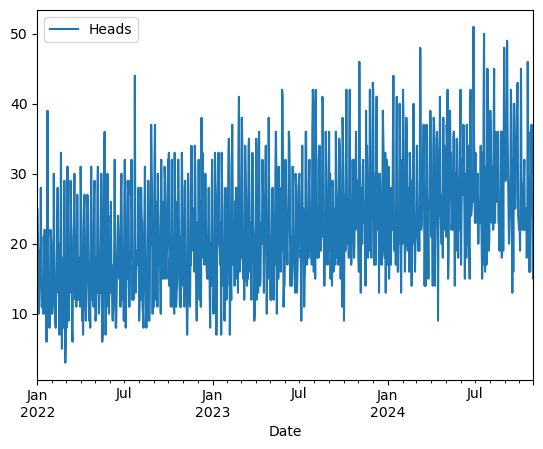

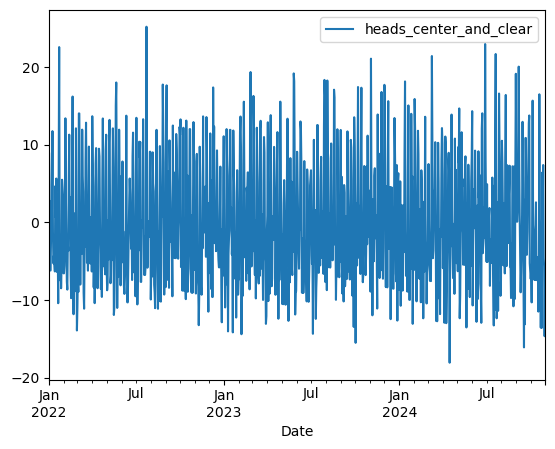

In [14]:
casino_fig_train.plot(x="Date", y ="Heads")
casino_fig_train.plot(x="Date", y ="heads_center_and_clear")

In [15]:
heads_train_df =casino_fig_train.groupby('week_day')['heads_center_and_clear'].agg([ 'mean','std'])

In [16]:
heads_train_df

,mean,std
week_day,,
0,-6.400727,4.118920
1,-4.988116,4.422588
2,-2.622804,4.507297
3,-5.487220,4.462926
4,7.922764,5.936481
5,9.301080,5.660319
6,2.328555,4.916721


### Добавляем тренд в тестовую выборку (для удобства его учёта при прогнозировании)

In [17]:
casino_fig_test['trend_heads']= poly_1(casino_fig_test.index)

### Делаем прогноз

In [18]:
predict = []
predict_3_std_plus = []
predict_3_std_minus = []
for curr_ind in casino_fig_test.index:
    week_day = casino_fig_test['week_day'].loc[curr_ind]
    trend = casino_fig_test['trend_heads'].loc[curr_ind]
    pred = trend + heads_train_df['mean'].loc[week_day]
    predict.append(pred)
    predict_3_std_plus.append(pred+3*heads_train_df['std'].loc[week_day])
    predict_3_std_minus.append(pred-3*heads_train_df['std'].loc[week_day])
    

In [20]:
casino_fig_test['predict'] = predict
casino_fig_test['predict_3_std_plus'] = predict_3_std_plus
casino_fig_test['predict_3_std_minus'] = predict_3_std_minus

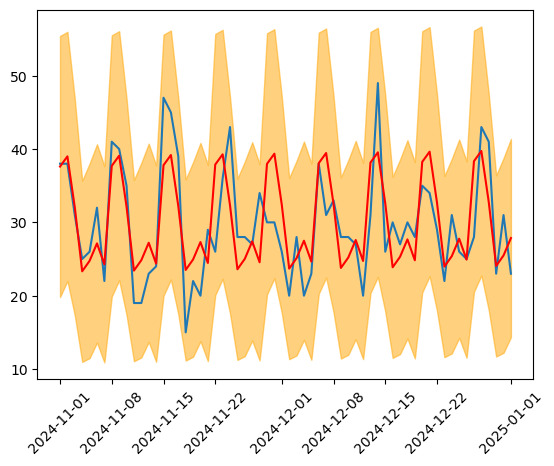

In [22]:
plt.plot(casino_fig_test['Date']  ,casino_fig_test['Heads'] )
plt.plot(casino_fig_test['Date'],casino_fig_test['predict'],color='red' )
plt.fill_between(casino_fig_test['Date'], casino_fig_test['predict_3_std_minus'], casino_fig_test['predict_3_std_plus'], alpha=0.5, color='orange')
plt.tick_params(axis='x', labelrotation=45)